# Курсовой проект

### 1. Подключение библиотек и скриптов

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import warnings
warnings.filterwarnings('ignore')

### 2. Пути к директориям файлам

In [2]:
# исходный файл
DATASET_PATH = 'C:/Курсовой проект Библиотеки/train.csv'

# тестовый датасет
TEST_DATASET_PATH = 'C:/Курсовой проект Библиотеки/test.csv'

# предсказания на тестовом датасете
PREDICTIONS = 'C:/Курсовой проект Библиотеки/IKaraseva_predictions.csv'

### 3. Загрузка данных

In [3]:
df = pd.read_csv(DATASET_PATH)

In [4]:
test_df = pd.read_csv(TEST_DATASET_PATH)

### 4. Уменьшение объема памяти, который занимает датасет

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


### 5. Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [7]:
df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [8]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [9]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### 6. Распределение целевой переменной

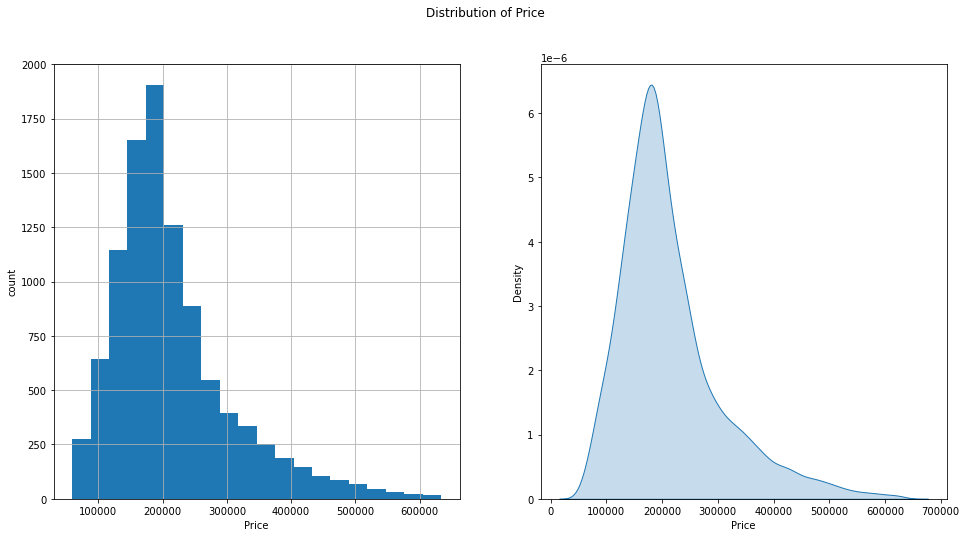

In [10]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

Выбросов нет, данные не требуют дополнительной обработки

### 7. Анализ признаков

In [11]:
# посмотрим все категориальные признаки
df.select_dtypes(include = ['object', 'category']).columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

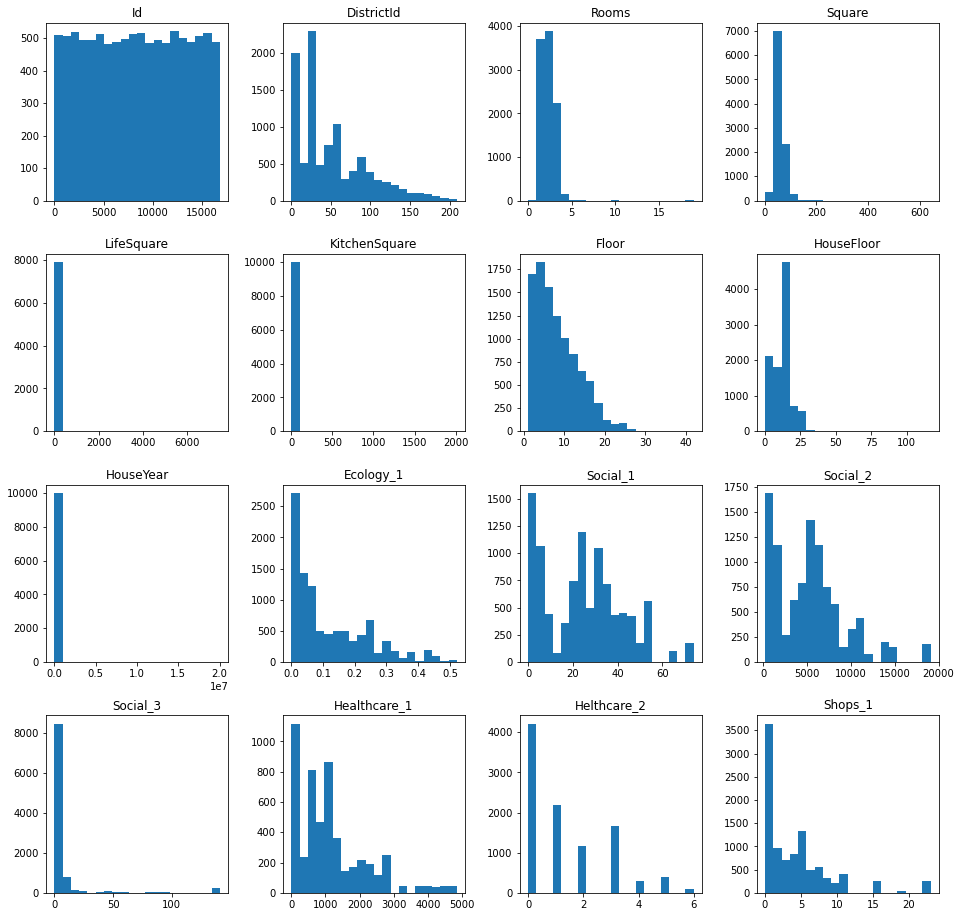

In [12]:
# посмотрим все количественные признаки на гистограммах
df_num_features = df.select_dtypes(include = ['float32', 'int32', 'int16', 'int8'])
df_num_features.drop('Price', axis = 1, inplace = True)
df_num_features.hist(figsize = (16, 16), bins = 20, grid = False);

### Количественные признаки

#### Работа с незаполненными данными - LifeSquare и Healthcare_1

#### LifeSquare

In [13]:
df['LifeSquare'].describe()

count    7887.000000
mean       37.199665
std        86.241219
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

In [14]:
# обработка выбросов
df.loc[(df['LifeSquare'] < 10) | (df['LifeSquare'] > 100), 'LifeSquare'] = df['LifeSquare'].median()

In [15]:
# заполним пропуски медианой
median_lifesquare = df['LifeSquare'].median()
df['LifeSquare'] = df['LifeSquare'].fillna(median_lifesquare)

<AxesSubplot:>

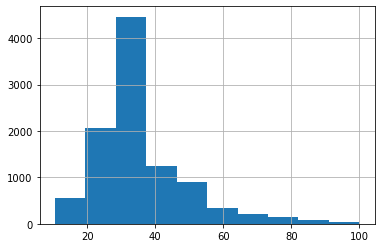

In [16]:
df['LifeSquare'].hist()

In [17]:
df['LifeSquare'].describe()

count    10000.000000
mean        35.433994
std         13.467802
min         10.523869
25%         27.654813
50%         32.781261
75%         41.052148
max         99.970062
Name: LifeSquare, dtype: float64

#### Healthcare_1

In [18]:
df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.519470
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

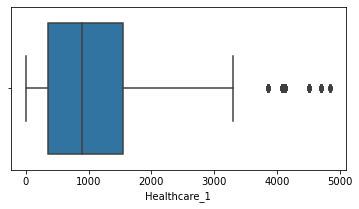

In [19]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Healthcare_1'], whis=1.5)

plt.xlabel('Healthcare_1')
plt.show()

In [20]:
df.loc[df['Healthcare_1'] > 3000, 'Healthcare_1' ] = df['Healthcare_1'].median()

In [21]:
median_healthcare1 = df['Healthcare_1'].median()
df['Healthcare_1'] = df['Healthcare_1'].fillna(median_healthcare1)

<AxesSubplot:>

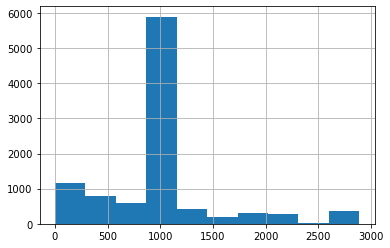

In [22]:
df['Healthcare_1'].hist()

In [23]:
df['Healthcare_1'].describe()

count    10000.000000
mean       944.553406
std        550.864868
min          0.000000
25%        830.000000
50%        900.000000
75%        900.000000
max       2890.000000
Name: Healthcare_1, dtype: float64

#### Обработка признака Rooms - количество комнат

In [24]:
df['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839522
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

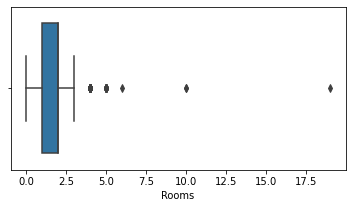

In [25]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

In [26]:
df.loc[(df['Rooms'] > 5) | (df['Rooms'] < 1), 'Rooms'] = df['Rooms'].median()

In [27]:
df['Rooms'].describe()

count    10000.000000
mean         1.888400
std          0.811071
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: Rooms, dtype: float64

In [28]:
df['Rooms'].value_counts().index

Float64Index([2.0, 1.0, 3.0, 4.0, 5.0], dtype='float64')

#### Обработка признака Square - общая площадь

In [29]:
df['Square'].describe()

count    10000.000000
mean        56.315720
std         21.058716
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

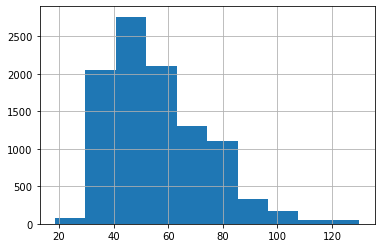

In [30]:
df.loc[(df['Square'] > 130) | (df['Square'] < 18), 'Square'] = df['Square'].median()
df['Square'].hist();

In [31]:
df['Square'].describe()

count    10000.000000
mean        55.734982
std         17.580727
min         18.509176
25%         41.807906
50%         52.513309
75%         65.684193
max        129.998749
Name: Square, dtype: float64

#### Обработка признака KitchenSquare - площадь кухни

In [32]:
df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560839
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [33]:
df.loc[(df['KitchenSquare'] > 20) | (df['KitchenSquare'] < 5), 'KitchenSquare'] = df['KitchenSquare'].median()

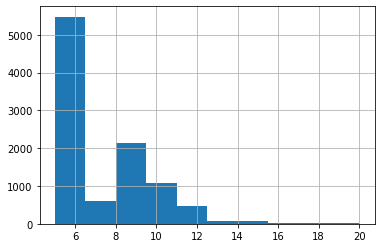

In [34]:
df['KitchenSquare'].hist();

In [35]:
df['KitchenSquare'].describe()

count    10000.000000
mean         7.339900
std          2.149602
min          5.000000
25%          6.000000
50%          6.000000
75%          9.000000
max         20.000000
Name: KitchenSquare, dtype: float64

In [36]:
df[((df['LifeSquare'] + df['KitchenSquare']) > df['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8,9951,1,1.0,46.887894,44.628132,6.0,12,20.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,160400.406250
9,8094,6,3.0,79.867477,75.085129,6.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.031250
19,367,45,1.0,42.367290,40.012527,6.0,16,14.0,2015,0.195781,B,B,23,5212,6,900.0,3,2,B,250466.984375
33,847,74,2.0,73.314972,74.131264,6.0,7,6.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,254005.375000
34,7757,27,2.0,58.783661,55.441257,11.0,13,12.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B,138396.984375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9965,6441,52,3.0,85.796883,85.305244,6.0,15,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,204462.984375
9979,2201,6,1.0,40.043236,41.984322,6.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.078125
9982,10268,27,1.0,36.112392,32.781261,6.0,9,16.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,94881.695312
9987,11665,1,2.0,62.690056,64.602936,10.0,19,22.0,2018,0.007122,B,B,1,264,0,900.0,0,1,B,203908.187500


In [37]:
df.loc[((df['LifeSquare'] + df['KitchenSquare']) > df['Square']), ['LifeSquare', 'KitchenSquare']] = df[['LifeSquare', 'KitchenSquare']].median()

<AxesSubplot:>

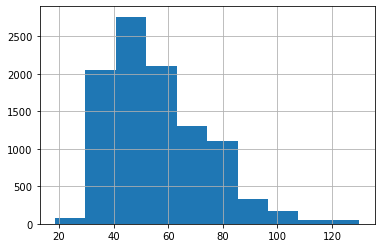

In [38]:
df['Square'].hist()

#### Обработка признака Floor - этаж

In [39]:
df['Floor'].describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

Данные не требуют обработки

#### Обработка признака HouseFloor - этажность дома

In [40]:
df['HouseFloor'].describe()

count    10000.0000
mean        12.6094
std          6.7762
min          0.0000
25%          9.0000
50%         13.0000
75%         17.0000
max        117.0000
Name: HouseFloor, dtype: float64

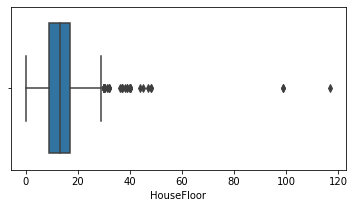

In [41]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['HouseFloor'], whis=1.5)

plt.xlabel('HouseFloor')
plt.show()

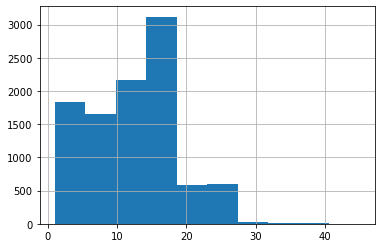

In [42]:
df.loc[(df['HouseFloor'] < 1) | (df['HouseFloor'] > 45), 'HouseFloor'] = df['HouseFloor'].median()
df['HouseFloor'].hist();

In [43]:
df['HouseFloor'].describe()

count    10000.000000
mean        12.921100
std          6.212187
min          1.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         45.000000
Name: HouseFloor, dtype: float64

In [44]:
df[(df['Floor'] > df['HouseFloor'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299601,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.921875
19,367,45,1.0,42.367290,NaN,NaN,16,14.0,2015,0.195781,B,B,23,5212,6,900.0,3,2,B,250466.984375
21,8471,20,3.0,75.611061,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.250000
25,4521,6,2.0,65.409966,32.781261,6.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.265625
26,8553,88,3.0,83.262527,32.781261,6.0,13,1.0,1977,0.127376,B,B,43,8429,3,900.0,3,9,B,410883.906250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,7659,57,1.0,38.485252,22.550608,8.0,19,17.0,1992,0.133215,B,B,49,11395,3,1406.0,3,4,A,183485.281250
9960,16258,48,3.0,96.056786,NaN,NaN,15,1.0,2017,0.041125,B,B,46,9515,5,900.0,1,10,B,524365.562500
9968,9920,1,3.0,86.487549,32.781261,6.0,18,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,248248.937500
9970,13501,6,1.0,41.310417,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.828125


In [45]:
df.loc[(df['Floor'] > df['HouseFloor']), ['Floor', 'HouseFloor']] = df[['Floor', 'HouseFloor']].median()

<AxesSubplot:>

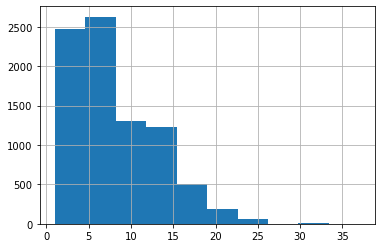

In [46]:
df['Floor'].hist()

#### Обработка признака Ecology_1

<AxesSubplot:>

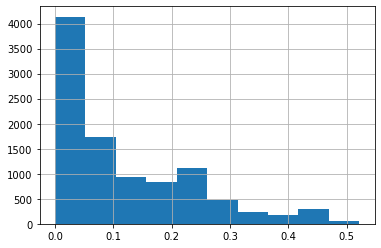

In [47]:
df['Ecology_1'].hist()

Не требует обработки

#### Обработка признака Social_1

<AxesSubplot:>

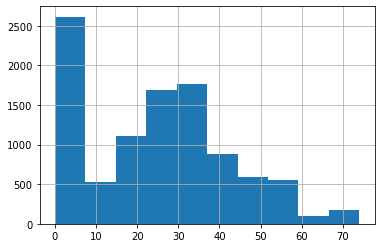

In [48]:
df['Social_1'].hist()

In [49]:
df.loc[((df['Social_1'] < 5) | (df['Social_1'] > 60)), 'Social_1'] = df['Social_1'].median()

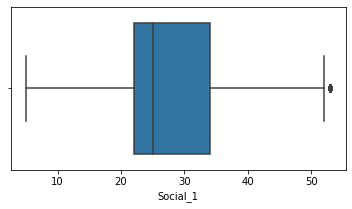

In [50]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Social_1'], whis=1.5)

plt.xlabel('Social_1')
plt.show()

<AxesSubplot:>

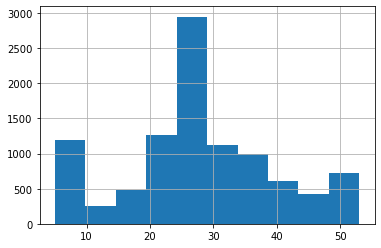

In [51]:
df['Social_1'].hist()

#### Обработка признака Social_2

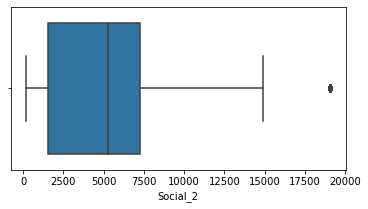

In [52]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Social_2'], whis=1.5)

plt.xlabel('Social_2')
plt.show()

In [53]:
df.loc[((df['Social_2'] < 500) | (df['Social_2'] > 14000)), 'Social_2'] = df['Social_2'].median()

<AxesSubplot:>

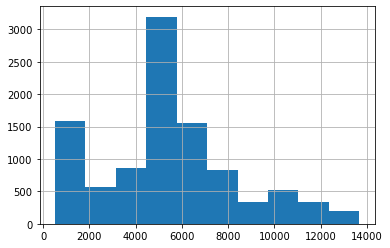

In [54]:
df['Social_2'].hist()

In [55]:
df['Social_2'].describe()

count    10000.000000
mean      5489.571400
std       2940.691314
min        507.000000
25%       3791.000000
50%       5285.000000
75%       6856.000000
max      13670.000000
Name: Social_2, dtype: float64

#### Обработка признака Social_3

In [56]:
df['Social_3'].describe()

count    10000.000000
mean         8.039200
std         23.831875
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        141.000000
Name: Social_3, dtype: float64

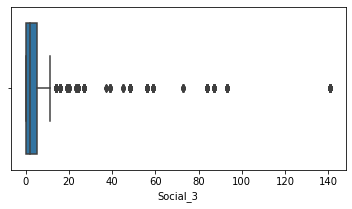

In [57]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Social_3'], whis=1.5)

plt.xlabel('Social_3')
plt.show()

In [58]:
df[((df['Social_3'] > 15) | (df['Social_3'] < 1))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,32.781261,10.0,4.0,10.0,2014,0.075424,B,B,11.0,3097.0,0,900.0,0,0,B,305018.875000
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,B,B,33.0,5261.0,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,32.781261,6.0,10.0,22.0,1977,0.007122,B,B,25.0,5285.0,0,900.0,0,1,B,168106.000000
8,9951,1,1.0,46.887894,NaN,NaN,12.0,20.0,1977,0.007122,B,B,25.0,5285.0,0,900.0,0,1,B,160400.406250
9,8094,6,3.0,79.867477,NaN,NaN,3.0,17.0,2014,0.243205,B,B,5.0,1564.0,0,540.0,0,0,B,194756.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,647,1,2.0,63.324024,32.781261,6.0,4.0,17.0,1977,0.007122,B,B,25.0,5285.0,0,900.0,0,1,B,183809.328125
9985,277,93,1.0,34.723984,19.840549,9.0,6.0,16.0,1988,0.521867,B,B,25.0,6149.0,0,900.0,0,0,B,149649.078125
9987,11665,1,2.0,62.690056,NaN,NaN,19.0,22.0,2018,0.007122,B,B,25.0,5285.0,0,900.0,0,1,B,203908.187500
9991,11173,6,2.0,62.648777,32.781261,6.0,6.0,17.0,1977,0.243205,B,B,5.0,1564.0,0,540.0,0,0,B,182625.546875


In [59]:
df.loc[((df['Social_3'] > 15) | (df['Social_3'] < 1)), 'Social_3'] = df['Social_3'].median()

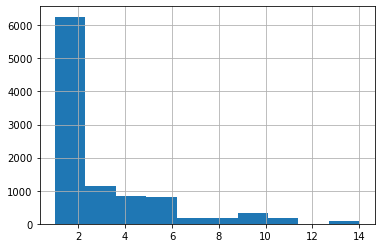

In [60]:
df['Social_3'].hist();

#### Обработка признака HouseYear

In [61]:
df['HouseYear'].describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [62]:
df[df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8828,11607,147,2.0,44.791836,28.360394,5.0,4.0,9.0,4968,0.319809,B,B,25.0,4756.0,2.0,2857.0,5,8,B,243028.609375
9163,10814,109,1.0,37.265072,20.239714,9.0,9.0,12.0,20052011,0.136330,B,B,30.0,6141.0,10.0,262.0,3,6,B,254084.531250


In [63]:
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [64]:
df['HouseYear'].describe()

count    10000.000000
mean      1984.872400
std         18.416347
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2020.000000
Name: HouseYear, dtype: float64

#### Обработка признаков Healthcare_1 и Helthcare_2	

<AxesSubplot:>

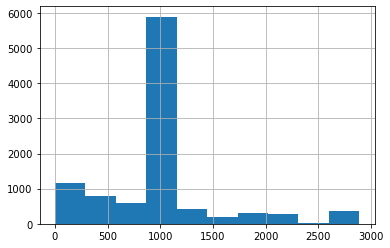

In [65]:
df['Healthcare_1'].hist()

<AxesSubplot:>

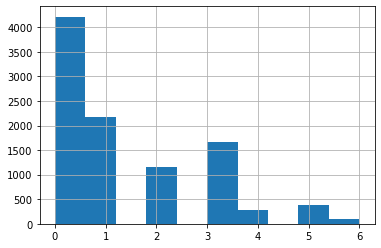

In [66]:
df['Helthcare_2'].hist()

Не требуют обработки

#### Обработка признака Shops_1


<AxesSubplot:>

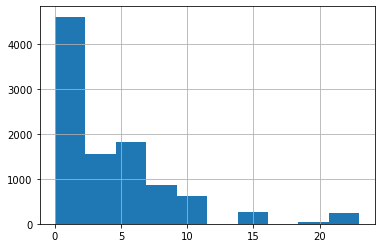

In [67]:
df['Shops_1'].hist()

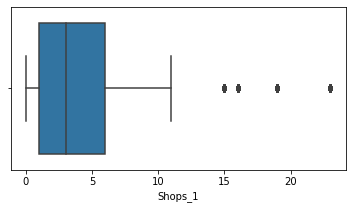

In [68]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Shops_1'], whis=1.5)

plt.xlabel('Shops_1')
plt.show()

In [69]:
df['Shops_1'].describe()

count    10000.000000
mean         4.231300
std          4.806341
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         23.000000
Name: Shops_1, dtype: float64

### Проверка результата

In [70]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,8665.000000,8665.000000,8387.000000,8387.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888400,55.734982,32.645927,7.392383,8.001192,13.971861,1984.872400,0.118858,27.389100,5489.571400,3.094200,944.553406,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.811071,17.580727,10.112997,2.166272,4.939510,5.632074,18.416347,0.119025,12.230522,2940.691314,2.485426,550.864868,1.493601,4.806341,92872.273438
min,0.00000,0.000000,1.000000,18.509176,10.523869,5.000000,1.000000,1.000000,1910.000000,0.000000,5.000000,507.000000,1.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.807906,24.479166,6.000000,4.000000,9.000000,1974.000000,0.017647,22.000000,3791.000000,2.000000,830.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.684193,34.994507,9.000000,11.000000,17.000000,2001.000000,0.195781,34.000000,6856.000000,4.000000,900.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,5.000000,129.998749,95.645828,20.000000,37.000000,45.000000,2020.000000,0.521867,53.000000,13670.000000,14.000000,2890.000000,6.000000,23.000000,633233.437500


### 7.2 Категориальные переменные

In [71]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [72]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [73]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [74]:
df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})

### 8. Очистка данных и Feature engineering

**Оставим признаки, которые необходимы для модели**

In [75]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin']

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     8665 non-null   float32 
 5   KitchenSquare  8665 non-null   float32 
 6   Floor          8387 non-null   float64 
 7   HouseFloor     8387 non-null   float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  float64 
 13  Social_2       10000 non-null  float64 
 14  Social_3       10000 non-null  float64 
 15  Healthcare_1   10000 non-null  float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [77]:
df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].median())
df['KitchenSquare'] = df['KitchenSquare'].fillna(df['KitchenSquare'].median())
df['Floor'] = df['Floor'].fillna(df['Floor'].median())
df['HouseFloor'] = df['HouseFloor'].fillna(df['HouseFloor'].median())

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     10000 non-null  float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  float64 
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  float64 
 13  Social_2       10000 non-null  float64 
 14  Social_3       10000 non-null  float64 
 15  Healthcare_1   10000 non-null  float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [79]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1','Ecology_2_bin',
                 'Ecology_3_bin', 'Shops_2_bin']

target_name = 'Price'

In [80]:
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,27,3.0,115.027313,32.781261,10.0,4.0,10.0,2014,0.075424,11.0,3097.0,2.0,900.0,0,0,1,1,1,305018.875000
1,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,30.0,6207.0,1.0,1183.0,1,0,1,1,1,177734.546875
2,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,33.0,5261.0,2.0,240.0,3,1,1,1,1,282078.718750
3,1,1.0,40.409908,32.781261,6.0,10.0,22.0,1977,0.007122,25.0,5285.0,2.0,900.0,0,1,1,1,1,168106.000000
4,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,33.0,8667.0,2.0,900.0,0,6,1,1,1,343995.093750


**Стандартизация признаков** 

In [81]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float64','int64', 'int32','int16']).columns.tolist()
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin']

In [82]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [83]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,-0.536895,1.370628,3.372737,0.012462,1.348705,-0.846061,-0.770987,1.581696,-0.364931,-1.340083,-0.813649,-0.440268,-0.080886,0,0,0.09897,0.16816,0.299864,305018.875000
1,-0.651613,-1.095417,-0.904592,-1.008638,0.383103,-0.185024,-1.158769,-1.024815,-0.002690,0.213485,0.243978,-0.842634,0.432894,1,0,0.09897,0.16816,0.299864,177734.546875
2,-1.133425,1.370628,1.285967,1.594322,1.348705,-1.286752,0.586248,0.169836,-0.783473,0.458785,-0.077731,-0.440268,-1.279100,3,1,0.09897,0.16816,0.299864,282078.718750
3,-1.133425,-1.095417,-0.871749,0.012462,-0.582500,0.476013,1.555702,-0.427489,-0.938799,-0.195349,-0.069569,-0.440268,-0.080886,0,1,0.09897,0.16816,0.299864,168106.000000
4,1.000316,0.137605,0.486349,0.626612,0.865904,1.798086,0.392357,-0.699001,1.377425,0.458785,1.080558,-0.440268,-0.080886,0,6,0.09897,0.16816,0.299864,343995.093750


### 9. Разбиение на train / test

In [84]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

### 10. Построение модели

По результатам оценки нескольких моделей LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor выбрана лучшая модель GradientBoostingRegressor

### 10.1 Gradient Boosting decision trees

In [85]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH)
    plt.show()

R2:	0.899
RMSE:	29078.732
MSE:	845572643.971


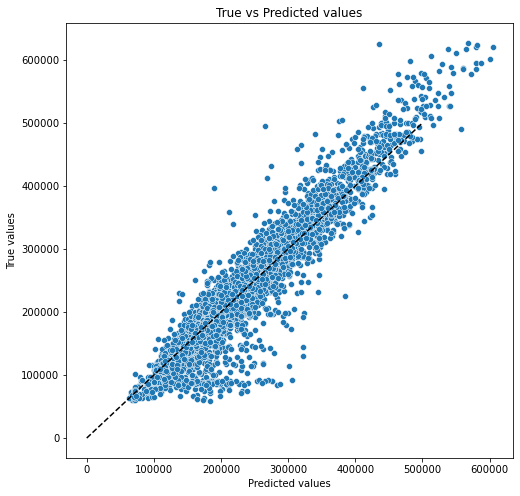

In [86]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.734
RMSE:	49532.717
MSE:	2453490092.02


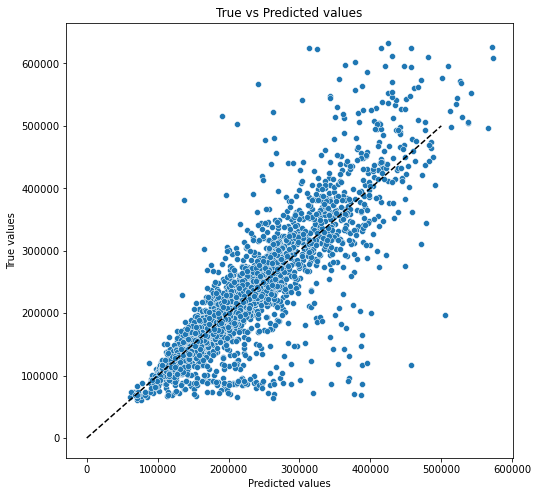

In [87]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### 11. Настройка и оценка финальной модели

In [88]:
#gb_model = GradientBoostingRegressor(criterion='mse',
#                          min_samples_leaf=10,
#                          random_state=42,
#                         # n_estimators=100,
#                         # max_depth=7
#                         )

In [89]:
#%%time
#params = {'n_estimators':[50, 100, 200, 400], 
#          'max_depth':[3, 5, 7, 10]}

#gs = GridSearchCV(gb_model, params, 
#                  scoring='r2', # метрика 
#                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                           random_state=21, 
#                           shuffle=True),
#                  n_jobs=-1
#                  )
#gs.fit(X_train, y_train)

In [90]:
#gs.best_params_
# определены лучшие параметры:
# {'max_depth': 5, 'n_estimators': 200}

In [91]:
#gs.best_score_
# 0.7299762587739833

**определены лучшие параметры:**
- {'max_depth': 5, 'n_estimators': 200}

**Обучение и оценка модели**

In [92]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=200)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=10,
                          n_estimators=200, random_state=42)

R2:	0.88
RMSE:	31594.672
MSE:	998223300.624


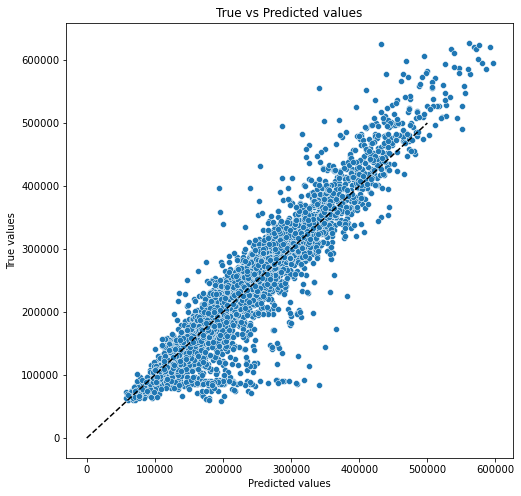

In [93]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train.values, y_train_preds)


R2:	0.738
RMSE:	49088.054
MSE:	2409637090.895


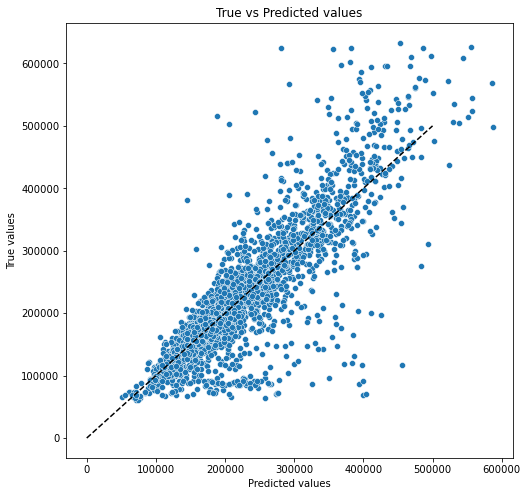

In [94]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**Важность признаков**

In [95]:
final_model.feature_importances_

array([1.12068626e-01, 6.09994751e-02, 3.70974361e-01, 8.44950663e-02,
       2.04822168e-02, 9.77359532e-03, 1.72530715e-02, 4.03017744e-02,
       4.60802364e-02, 1.94466554e-02, 6.94455734e-02, 6.12945439e-02,
       2.27376227e-02, 3.71671975e-02, 2.71427354e-02, 6.09231724e-05,
       1.40324449e-04, 1.36001476e-04])

In [96]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [97]:
feature_importances.head()

,feature_name,importance
2,Square,0.370974
0,DistrictId,0.112069
3,LifeSquare,0.084495
10,Social_2,0.069446
11,Social_3,0.061295


In [98]:
feature_importances.tail()

,feature_name,importance
6,HouseFloor,0.017253
5,Floor,0.009774
16,Ecology_3_bin,0.000140
17,Shops_2_bin,0.000136
15,Ecology_2_bin,0.000061


### ТЕСТОВАЯ МОДЕЛЬ

In [99]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [100]:
test_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [101]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [102]:
test_df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

#### Обработка количественных признаков

In [103]:
test_df.loc[(test_df['LifeSquare'] < 10) | (test_df['LifeSquare'] > 100), 'LifeSquare'] = test_df['LifeSquare'].median()
median_lifesquare = test_df['LifeSquare'].median()
test_df['LifeSquare'] = test_df['LifeSquare'].fillna(median_lifesquare)

In [104]:
test_df.loc[test_df['Healthcare_1'] > 3000, 'Healthcare_1' ] = test_df['Healthcare_1'].median()
median_healthcare1 = test_df['Healthcare_1'].median()
test_df['Healthcare_1'] = test_df['Healthcare_1'].fillna(median_healthcare1)

In [105]:
test_df.loc[(test_df['Rooms'] > 5) | (test_df['Rooms'] < 1), 'Rooms'] = test_df['Rooms'].median()

In [106]:
test_df.loc[(test_df['Square'] > 130) | (test_df['Square'] < 18), 'Square'] = test_df['Square'].median()

In [107]:
test_df.loc[(test_df['KitchenSquare'] > 20) | (test_df['KitchenSquare'] < 5), 'KitchenSquare'] = test_df['KitchenSquare'].median()
test_df.loc[((test_df['LifeSquare'] + test_df['KitchenSquare']) > test_df['Square']), ['LifeSquare', 'KitchenSquare']] = test_df[['LifeSquare', 'KitchenSquare']].median()
test_df['LifeSquare'] = test_df['LifeSquare'].fillna(test_df['LifeSquare'].median())
test_df['KitchenSquare'] = test_df['KitchenSquare'].fillna(test_df['KitchenSquare'].median())

In [108]:
test_df.loc[(test_df['HouseFloor'] < 1) | (test_df['HouseFloor'] > 45), 'HouseFloor'] = test_df['HouseFloor'].median()
test_df.loc[(test_df['Floor'] > test_df['HouseFloor']), ['Floor', 'HouseFloor']] = test_df[['Floor', 'HouseFloor']].median()
test_df['Floor'] = test_df['Floor'].fillna(test_df['Floor'].median())
test_df['HouseFloor'] = test_df['HouseFloor'].fillna(test_df['HouseFloor'].median())

In [109]:
test_df.loc[((test_df['Social_1'] < 5) | (test_df['Social_1'] > 60)), 'Social_1'] = test_df['Social_1'].median()
test_df.loc[((test_df['Social_2'] < 500) | (test_df['Social_2'] > 14000)), 'Social_2'] = test_df['Social_2'].median()
test_df.loc[((test_df['Social_3'] > 15) | (test_df['Social_3'] < 1)), 'Social_3'] = test_df['Social_3'].median()

In [110]:
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'] = 2020

#### Обработка категориальных признаков

In [111]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [112]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,4567,44,1.0,36.847630,19.094183,5.0,5.0,9.0,1970,0.036122,...,24.0,4378.0,2.0,1036.0,1,1,B,1,1,1
1,5925,62,1.0,42.493908,32.925087,6.0,7.0,17.0,2017,0.072158,...,25.0,629.0,1.0,900.0,0,0,A,1,1,0
2,960,27,2.0,59.463676,32.925087,9.0,19.0,19.0,1977,0.211401,...,9.0,1892.0,2.0,900.0,0,1,B,1,1,1
3,3848,23,3.0,49.646030,33.893826,6.0,2.0,2.0,1965,0.014073,...,25.0,5285.0,2.0,900.0,0,0,B,1,1,1
4,746,74,1.0,53.837055,32.925087,6.0,8.0,17.0,1977,0.309479,...,35.0,7715.0,4.0,990.0,0,6,B,1,1,1


In [113]:
test_df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Ecology_2_bin    0
Ecology_3_bin    0
Shops_2_bin      0
dtype: int64

In [114]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     5000 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   float64 
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   float64 
 13  Social_2       5000 non-null   float64 
 14  Social_3       5000 non-null   float64 
 15  Healthcare_1   5000 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

In [115]:
test_df = test_df[feature_names]

In [116]:
feature_names_for_stand = test_df[feature_names].select_dtypes(include=['float32', 'float64', 'int16', 'int64']).columns.tolist()
stand_features = scaler.fit_transform(test_df[feature_names_for_stand])
test_df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,-0.164781,-1.124521,-1.095312,-1.477855,-1.067114,-0.625421,-0.911136,-0.774992,-0.697594,-0.292421,-0.390392,-0.459181,0.180597,1,1,0.098453,0.175258,0.299666
1,0.242689,-1.124521,-0.772879,0.007533,-0.574221,-0.191071,0.594376,1.755796,-0.397445,-0.211247,-1.667970,-0.847988,-0.067520,0,0,0.098453,0.175258,-3.337053
2,-0.549613,0.116398,0.196185,0.007533,0.904460,2.415031,0.970755,-0.398066,0.762360,-1.510031,-1.237567,-0.459181,-0.067520,0,1,0.098453,0.175258,0.299666
3,-0.640162,1.357317,-0.364455,0.111572,-0.574221,-1.276946,-2.228460,-1.044225,-0.881250,-0.211247,-0.081306,-0.459181,-0.067520,0,0,0.098453,0.175258,0.299666
4,0.514336,-1.124521,-0.125125,0.007533,-0.574221,0.026104,0.594376,-0.398066,1.579283,0.600493,0.746785,0.318433,0.096675,0,6,0.098453,0.175258,0.299666


In [117]:
submit = pd.read_csv('C:/Курсовой проект Библиотеки/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [118]:
predictions = final_model.predict(test_df)
predictions

array([173382.5981679 , 126306.91763371, 157026.94423992, ...,
       146432.95191348, 183902.85379466, 275830.48154692])

In [119]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,173382.598168
1,5925,126306.917634
2,960,157026.944240
3,3848,139948.337568
4,746,247080.518727


In [120]:
submit.to_csv(PREDICTIONS, index=False)